# Pulse Shape Discrimination using K-means Algorithm

In [1]:
%pylab inline
import sys
sys.path.insert(0, '../modules')
import numpy as np
import math

Populating the interactive namespace from numpy and matplotlib


In [2]:
from root_numpy import root2array
from data import AlCapROOT

## Import the raw hits

In [3]:
alcapana = root2array("../data/alcapana_out/test_tree_3.root", treename="ADCTree")

In [4]:
# Sanity checks
print alcapana.dtype.names
print set(alcapana["pulse_len"])

('adc_val', 'pulse_len')
set([152])


In [5]:
# Stack the data by pulse
n_bins = 152
n_pulses = len(alcapana["pulse_len"])/n_bins
print "Start with {} pulses".format(n_pulses)
pulses = np.vstack( [alcapana["adc_val"][pulse*n_bins:(pulse+1)*n_bins] for pulse in range(n_pulses)] )

Start with 690549 pulses


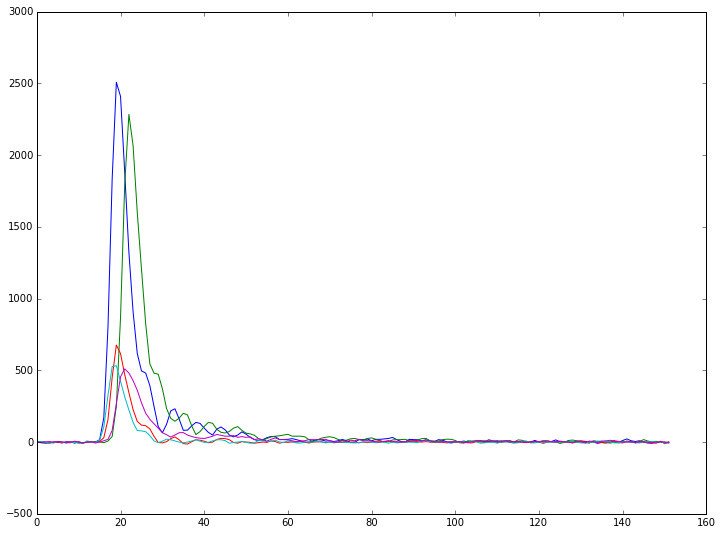

In [12]:
x_axis = range(n_bins)
figsize(12,9)
for event in range(5):
    y_axis = pulses[event]
    plot(x_axis,y_axis)


## Define the Features used for classification

In [7]:
# Define some features
max_height = np.hstack([np.amax(pulses[p]) for p in range(n_pulses)])
time_of_max = np.hstack([ np.where(pulses[p] == np.amax(pulses[p]))[0][0] for p in range(n_pulses)])

In [8]:
# Remove outliers before continuing
## Cut on max and mix adc values
adc_max = 15850
adc_min = 100
## Cut on time of max
time_mim = 16
time_max = 62

good_height = np.where( (max_height > adc_min) & (max_height < adc_max) )[0]
good_time = np.where( (time_of_max > time_mim) & (time_of_max < time_max))[0]

## Get all of these conditions
good_pulses = np.intersect1d(good_height, good_time)
n_good_pulses= len(good_pulses)
print "Removed {} pulses".format(n_pulses - n_good_pulses)

Removed 3772 pulses


In [9]:
t_1 = -5
t_2 = 9
t_end = 80
rise_integral = np.hstack([ sum(pulses[p][time_of_max[p]+t_1:time_of_max[p]+t_end]) for p in range(n_pulses)])
fall_integral = np.hstack([ sum(pulses[p][time_of_max[p]+t_2:time_of_max[p]+t_end]) for p in range(n_pulses)])

In [10]:
# Remove outliers before continuing
good_rise = np.where(rise_integral > 0)[0]
good_fall = np.where(fall_integral > 0)[0]

good_pulses = np.intersect1d(good_rise, good_pulses)
good_pulses = np.intersect1d(good_fall, good_pulses)

n_good_pulses= len(good_pulses)
print "Removed {0} pulses, i.e. {1:.3f}% of pulses".format( (n_pulses - n_good_pulses), 1 - float(n_good_pulses)/n_pulses)

Removed 7629 pulses, i.e. 0.011% of pulses


In [11]:
from collections import OrderedDict
features = OrderedDict()
features['max_height'] = max_height[good_pulses]
features['time_of_max'] = time_of_max[good_pulses]
features['rise_integral'] = rise_integral[good_pulses]
features['fall_integral'] = fall_integral[good_pulses]

## Benchmark Plot

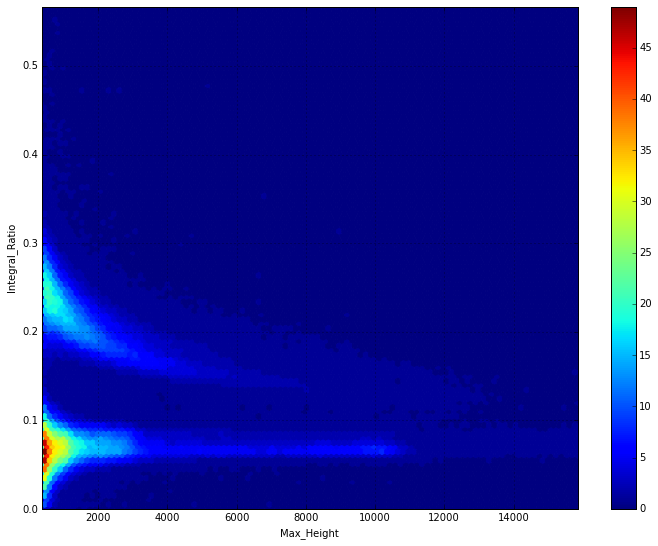

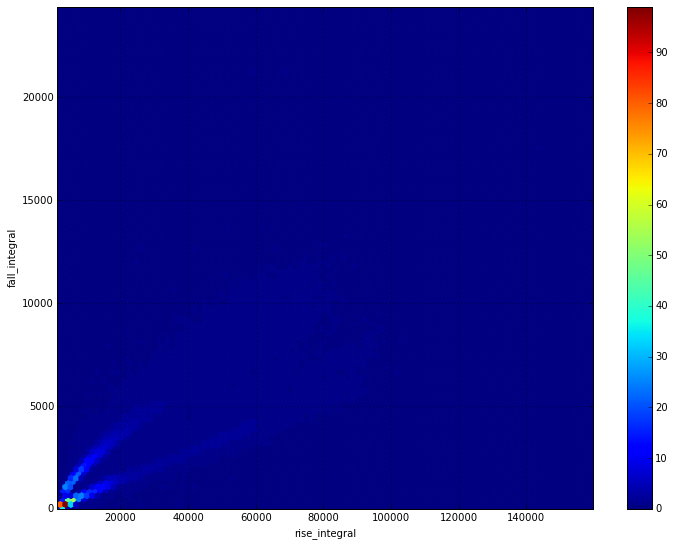

In [23]:
import pandas
from sklearn.decomposition import PCA
from sklearn import preprocessing

figsize(12,9)
integral_ratio = np.divide(features['fall_integral'].astype(float),features['rise_integral'])
data_orig = np.vstack([features['max_height'], integral_ratio])
data_orig =  data_orig.transpose()

psd_orig = pandas.DataFrame(data=data_orig, columns=['Max_Height','Integral_Ratio'])
psd_orig.plot(kind='hexbin',  x='Max_Height', y='Integral_Ratio', bins=50, cmap="jet")
show()

data_orig = np.vstack([features['rise_integral'], features['fall_integral']])
data_orig =  data_orig.transpose()

psd_orig = pandas.DataFrame(data=data_orig, columns=['rise_integral','fall_integral'])
psd_orig.plot(kind='hexbin',  x='rise_integral', y='fall_integral', bins=100, cmap="jet")
show()


In [24]:
scale_features = OrderedDict()
scale_features['max_height'] = preprocessing.scale(max_height[good_pulses].astype(float))
#scale_features['time_of_max'] = preprocessing.scale(time_of_max[good_pulses].astype(float))
scale_features['rise_integral'] = preprocessing.scale(rise_integral[good_pulses].astype(float))
scale_features['fall_integral'] = preprocessing.scale(fall_integral[good_pulses].astype(float))

data = np.vstack(scale_features.values())
data =  data.transpose()
print data.shape
n_feats = data.shape[-1]

(682920, 3)


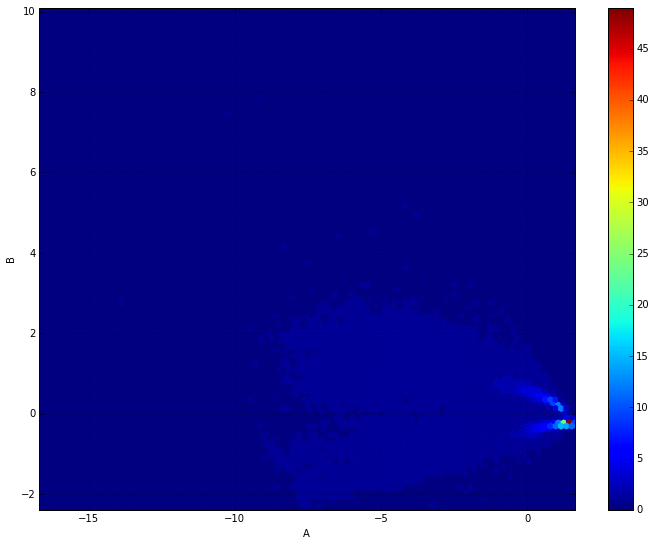

In [25]:
reduced_data = PCA(n_components=2).fit_transform(data)
decomp = pandas.DataFrame(data=reduced_data, columns=['A','B'])
decomp.plot(kind='hexbin',  x='A', y='B', bins=50, cmap="jet")

Automatically created module for IPython interactive environment


/usr/lib64/python2.7/site-packages/sklearn/utils/validation.py:332: UserWarning: StandardScaler assumes floating point values as input, got int64
  "got %s" % (estimator, X.dtype))


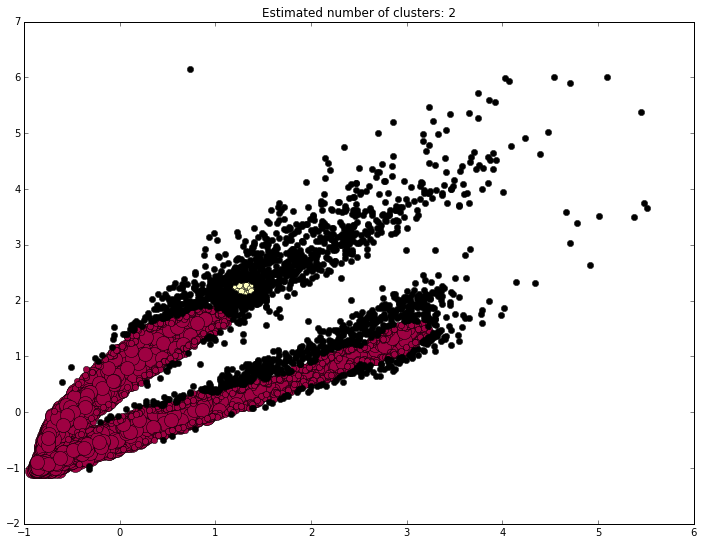

In [26]:
print(__doc__)

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


##############################################################################

X = StandardScaler().fit_transform(data_orig[0:20000])

##############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.1, min_samples=40).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

##############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## Split data into training and testing samples

In [27]:
from sklearn.cross_validation import train_test_split
train_events, test_events = train_test_split(range(n_good_pulses), train_size=0.25, test_size=0.25)

In [28]:
train_data, test_data = data[train_events], data[test_events]

In [29]:
import pandas
train_data = pandas.DataFrame(data=train_data, columns=features.keys())
test_data = pandas.DataFrame(data=test_data, columns=features.keys())

ValueError: Shape of passed values is (3, 170730), indices imply (4, 170730)

## Run Some Classifiers

In [ ]:
from rep.metaml.factory import ClassifiersFactory
from rep.estimators import SklearnClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [ ]:
#factory = ClassifiersFactory()
#kmeans_base = SklearnClassifier(KMeans(n_clusters=2), features=features.keys())
#factory.add_classifier('KMeans Base', kmeans_base)